In [1]:
set.seed(42)

In [2]:
beetles_data <- read.csv(file="./beetles.csv", header=TRUE)

 head(beetles_data)

,days,beetles
,<int>,<int>
1,0,2
2,8,47
3,28,192
4,41,256
5,63,768
6,79,896


In [3]:
t <- beetles_data$days
y <- beetles_data$beetles

sprintf("Number of days: %d", length(t))
sprintf("Number of beetles: %d", length(y))

[1] "Number of days: 10"

[1] "Number of beetles: 10"

In [5]:
N0 <- y[1]

population_func <- function(t, k, r) {
    k*N0 / (N0 + (k - N0)*exp(-r*t))
}

### Naive Newton method

Given:

$\log(N_{t})$ $\thicksim$ $\mathcal{N}(\log\{g(t)\}, \sigma^2)$

In [6]:
t <- beetles_data$days
y <- log(beetles_data$beetles)

In [7]:
loglikelihood_func <- function(t, y, params) {
    log_g <- log(population_func(t, params$k, params$r))
    delta <- y - log_g
    log_l <- (-1/2)*log(2*pi*params$var) - (delta^2)/(2*params$var)

    sum(log_l)
}

In [8]:
h_prime_func <- function(t, params) {
    h_prime_k <- exp(-params$r*t)
    h_prime_r <- -t*(params$k - N0)*exp(-params$r*t)

    list(k=h_prime_k, r=h_prime_r)
}

f_prime_func <- function(t, params) {
    h <- N0 + (params$k - N0)*exp(-params$r*t)
    h_prime <- h_prime_func(t, params)
    f_prime_k <- 1/params$k + (1/h)*h_prime$k
    f_prime_r <- (1/h)*h_prime$r

    list(k=f_prime_k, r=f_prime_r)    
}

loglike_prime_func <- function(t, y, params) {
    log_g <- log(population_func(t, params$k, params$r))
    delta <- y - log_g
    log_g_prime <- f_prime_func(t, params)
    n <- length(t)
    
    l_prime_k <- (1/params$var)*sum(delta*log_g_prime$k)
    l_prime_r <- (1/params$var)*sum(delta*log_g_prime$r)
    l_prime_var <- -n/(2*params$var) + sum(delta^2)/(2*params$var^2)

    c(l_prime_k, l_prime_r, l_prime_var)
}

In [9]:
f_2prime_func <- function(t, params) {
    exp_rt <- exp(-params$r*t)
    h <- N0 + (params$k - N0)*exp_rt
    h_prime <- h_prime_func(t, params)
    
    f_2prime_kk <- -1/params$k^2 - h_prime$k*(1/h^2)*exp_rt
    f_2prime_rr <- -t*(N0/h^2)*h_prime$r
    f_2prime_rk <- (-t*exp_rt*h - h_prime$r*exp_rt)/h^2

    list(kk=f_2prime_kk, rr=f_2prime_rr, rk=f_2prime_rk)
}

loglike_2prime_func <- function(t, params) {
    log_g <- log(population_func(t, params$k, params$r))
    f_prime <- f_prime_func(t, params)
    f_2prime <- f_2prime_func(t, params)
    delta <- y - log_g
    n <- length(t)

    l_2prime_kk <- (1/params$var)*sum(f_2prime$kk*delta - f_prime$k^2)
    l_2prime_rr <- (1/params$var)*sum(f_2prime$rr*delta - f_prime$r^2)
    l_2prime_varvar <- n/(2*params$var^2) - (1/params$var^3)*sum(delta^2) 
    l_2prime_kvar <- (-1/params$var^2)*sum(delta*f_prime$k)
    l_2prime_rvar <- (-1/params$var^2)*sum(delta*f_prime$r)
    l_2prime_rk <- (1/params$var)*sum(f_2prime$rk*delta - f_prime$k*f_prime$r)

    rbind(
        c(l_2prime_kk, l_2prime_rk, l_2prime_kvar),
        c(l_2prime_rk, l_2prime_rr, l_2prime_rvar),
        c(l_2prime_kvar, l_2prime_rvar, l_2prime_varvar)
    )
}

\begin{align*}
    \mathbb{E}\left[-\frac{\partial^{2}{L}}{\partial{K}^2}\right] &= \frac{1}{\sigma^2}\sum_{i=1}^{M}\left(\frac{\partial f}{\partial{K}}\right)^2 \\
    \mathbb{E}\left[-\frac{\partial^{2}{L}}{\partial{r}^2}\right] &= \frac{1}{\sigma^2}\sum_{i=1}^{M}\left(\frac{\partial f}{\partial{r}}\right)^2 \\
    \mathbb{E}\left[-\frac{\partial^{2}{L}}{\partial{r}\partial{K}}\right] &= \frac{1}{\sigma^2}\sum_{i=1}^{M}\frac{\partial f}{\partial{r}}\frac{\partial f}{\partial{K}} \\
    \mathbb{E}\left[-\frac{\partial^{2}{L}}{(\partial{\sigma^2})^2}\right] &= \frac{M}{2\sigma^4}
\end{align*}

In [10]:
# caculating fisher matrix function
fisher_matrix_func <- function(t, params) {
    f_prime <- f_prime_func(t, params)
    n <- length(t)
    w1 <- (1/params$var)*sum(f_prime$k^2)
    w2 <- (1/params$var)*sum(f_prime$r^2)
    w12 <- (1/params$var)*sum(f_prime$k*f_prime$r)
    w3 <- n/(2*params$var^2)
    w <- rbind(
        c(w1, w12, 0),
        c(w12, w2, 0),
        c(0, 0, w3)
    )

    return(w)
}

In [11]:
hess_appx_func <- function(t, params, method="hess") {
    switch(method,
           hess = loglike_2prime_func(t, params),
           fisher = -fisher_matrix_func(t, params),
           loglike_2prime_func(t, params)
          )
}

In [12]:
newtonlike_updating <- function(params, M, grad, a=1.) {
    d <- -solve(M, grad)
    
    params$k <- params$k + a*d[1]
    params$r <- params$r + a*d[2]
    params$var <- params$var + a*d[3]
    return(params)
}

update_history <- function(history, iter, obj_val) {
    history$iter <- append(history$iter, iter)
    history$obj_val <- append(history$obj_val, obj_val)

    history
}

err_func <- function(old_params, params) {
    old_params <- c(old_params$k, old_params$r, old_params$var)
    params <- c(params$k, params$r, params$var)

    norm(params - old_params, type="2")
}

In [13]:
newton_optimizer <- function(t, y, max_iter, threshold, params, start_a=1., hess_method="hess") {
    history <- list(iter<-list(), obj_val<-list())
    init_obj_val <- loglikelihood_func(t, y, params)
    history <- update_history(history, 0, init_obj_val)
    a <- start_a
    
    for (i in 1:max_iter) {
        iter <- i
        old_params <- params
        loglike_prime <- loglike_prime_func(t, y, old_params)
        M <- hess_appx_func(t, old_params, hess_method)
        params <- newtonlike_updating(old_params, M, loglike_prime, a)
        
        new_obj_val <- loglikelihood_func(t, y, params)
        history <- update_history(history, iter, new_obj_val)
        
        err <- err_func(old_params, params)
        if (err <= threshold) {
            print(sprintf("Stop at iter: %d", iter))
            break
        }
    }

    return(list(params=params, history=history))
}

[1] "Starting point: K=28.2961, r=1.4371, var=4.1282"

[1] "Optimal points: K=499.4574, r=5.0403, var=0.9727"

[1] "Final loglikelihood value: -14.0510"

[1] "Best loglikelihood value: -14.0510"

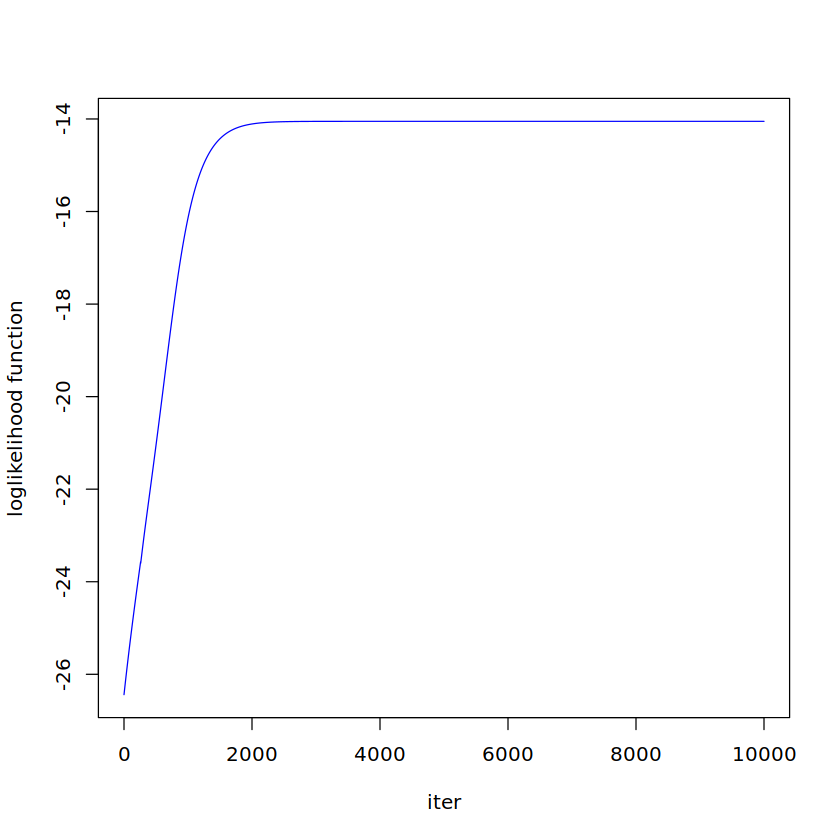

In [14]:
max_iter <- 10000
threshold <- 1e-5
start_a <- 0.003
init_params <- list(
    k = runif(1,min=10., max=30.),
    r = runif(1,min=0.5, max=1.5),
    var = var(y)
)
sprintf("Starting point: K=%.4f, r=%.4f, var=%.4f", init_params$k, init_params$r, init_params$var)

result <- newton_optimizer(t, y, max_iter, threshold, init_params, start_a)
plot(
    result$history$iter,
    result$history$obj_val,
    type = 'l',
    col = 'blue',
    xlab = 'iter',
    ylab = 'loglikelihood function'
)

sprintf("Optimal points: K=%.4f, r=%.4f, var=%.4f", result$params$k, result$params$r, result$params$var)
sprintf("Final loglikelihood value: %.4f", loglikelihood_func(t, y, result$params))
sprintf("Best loglikelihood value: %.4f", max(result$history$obj_val))

### Fisher scoring method

[1] "Starting point: K=0.5474, r=0.9034, var=0.5410"

[1] "Optimal points: K=24.5535, r=-0.1128, var=88.7643"

[1] "Final loglikelihood value: -44.2148"

[1] "Best loglikelihood value: -33.8582"

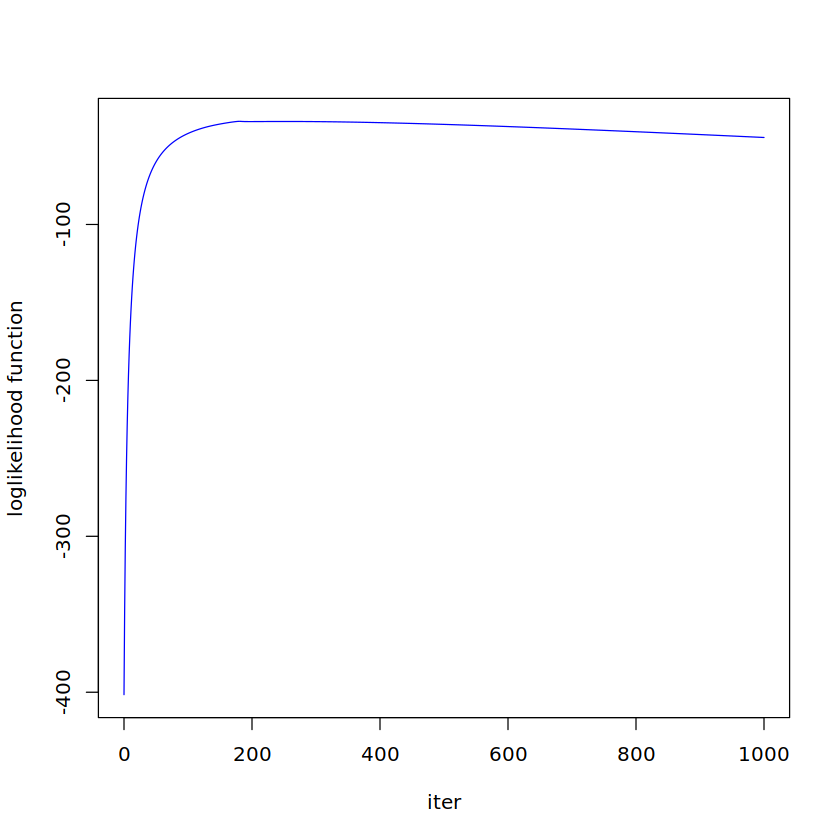

In [25]:
max_iter <- 1000
threshold <- 1e-5
start_a <- 0.002
init_params <- list(
    k = 0.5474,
    r =0.9034,
    var = 0.5410
)
sprintf("Starting point: K=%.4f, r=%.4f, var=%.4f", init_params$k, init_params$r, init_params$var)

result <- newton_optimizer(t, y, max_iter, threshold, init_params, start_a, hess_method="fisher")
plot(
    result$history$iter,
    result$history$obj_val,
    type = 'l',
    col = 'blue',
    xlab = 'iter',
    ylab = 'loglikelihood function'
)

sprintf("Optimal points: K=%.4f, r=%.4f, var=%.4f", result$params$k, result$params$r, result$params$var)
sprintf("Final loglikelihood value: %.4f", loglikelihood_func(t, y, result$params))
sprintf("Best loglikelihood value: %.4f", max(result$history$obj_val))

### Quasi-Newton method

In [16]:
hess_updating <- function(t, y, params, old_params, M, old_grad) {
    grad <- loglike_prime_func(t, y, params)

    # convert list to vector
    params <- c(params$k, params$r, params$var)
    old_params <- c(old_params$k, old_params$r, old_params$var)
    
    h <- params - old_params
    u <- grad - old_grad
    h_trans <- t(h)
    m_h <- M %*% h
    num1 <- m_h %*% t(m_h)
    de1 <- as.numeric(h_trans %*% m_h)
    num2 <- u %*% t(u)
    de2 <- as.numeric(h_trans %*% u)

    M <- M - num1/de1 + num2/de2
}

bfgs_optimizer <- function(t, y, max_iter, threshold, params, M, start_a) {
    history <- list(iter<-list(), obj_val<-list())
    init_obj_val <- loglikelihood_func(t, y, params)
    history <- update_history(history, 0, init_obj_val)
    
    for (i in 1:max_iter) {
        iter <- i
        a <- start_a
        old_params <- params
        old_obj_val <- loglikelihood_func(t, y, old_params)
        loglike_prime <- loglike_prime_func(t, y, old_params)
        params <- newtonlike_updating(old_params, M, loglike_prime, a)

        for (j in 1:10) {
            new_obj_val <- loglikelihood_func(t, y, params)
            if (new_obj_val > old_obj_val) {
                break
            }
            a <- a / 2.
            params <- newtonlike_updating(old_params, M, loglike_prime, a)
        }
        
        history <- update_history(history, iter, new_obj_val)
        err <- err_func(old_params, params)
        if (err <= threshold) {
            print(sprintf("Stop at iter: %d", iter))
            break
        }
        
        M <- hess_updating(t, y, params, old_params, M, loglike_prime)
    }

    return(list(params=params, history=history))
}

Run with $M = -diag(1,1,\dots,1)$

[1] "Starting point: K=0.2861, r=0.8304, var=0.6417"

[1] "Optimal points: K=43.7473, r=2.9796, var=9.4078"

[1] "Final loglikelihood value: -23.7504"

[1] "Best loglikelihood value: -23.7504"

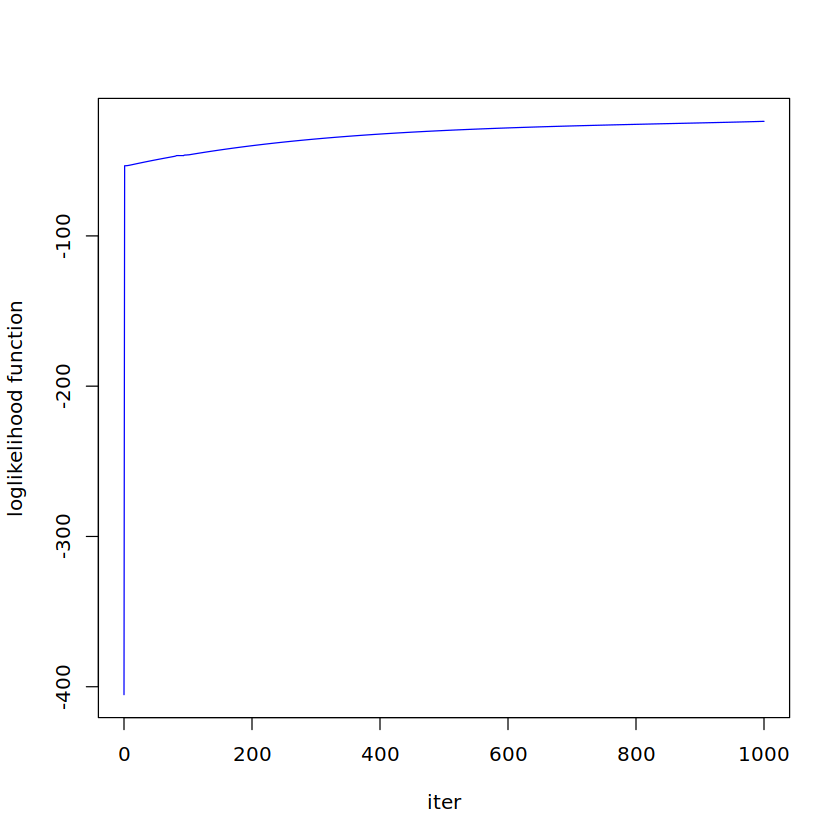

In [17]:
max_iter <- 1000
threshold <- 1e-5
start_a <- 0.005
init_params <- list(
    k= runif(1,min=0, max=1),
    r= runif(1,min=0, max=1),
    var=runif(1,min=0, max=1)
)
M <- -diag(c(1, 1, 1), 3, 3)
sprintf("Starting point: K=%.4f, r=%.4f, var=%.4f", init_params$k, init_params$r, init_params$var)

result <- bfgs_optimizer(t, y, max_iter, threshold, init_params, M, start_a)
plot(
    result$history$iter,
    result$history$obj_val,
    type = 'l',
    col = 'blue',
    xlab = 'iter',
    ylab = 'loglikelihood function'
)

sprintf("Optimal points: K=%.4f, r=%.4f, var=%.4f", result$params$k, result$params$r, result$params$var)
sprintf("Final loglikelihood value: %.4f", loglikelihood_func(t, y, result$params))
sprintf("Best loglikelihood value: %.4f", max(result$history$obj_val))

Run with $M = -fisher$

[1] "Starting point: K=0.1175, r=0.4750, var=0.5603"

[1] "Optimal points: K=42.1542, r=1164.7462, var=22.2171"

[1] "Final loglikelihood value: -26.1505"

[1] "Best loglikelihood value: -25.9497"

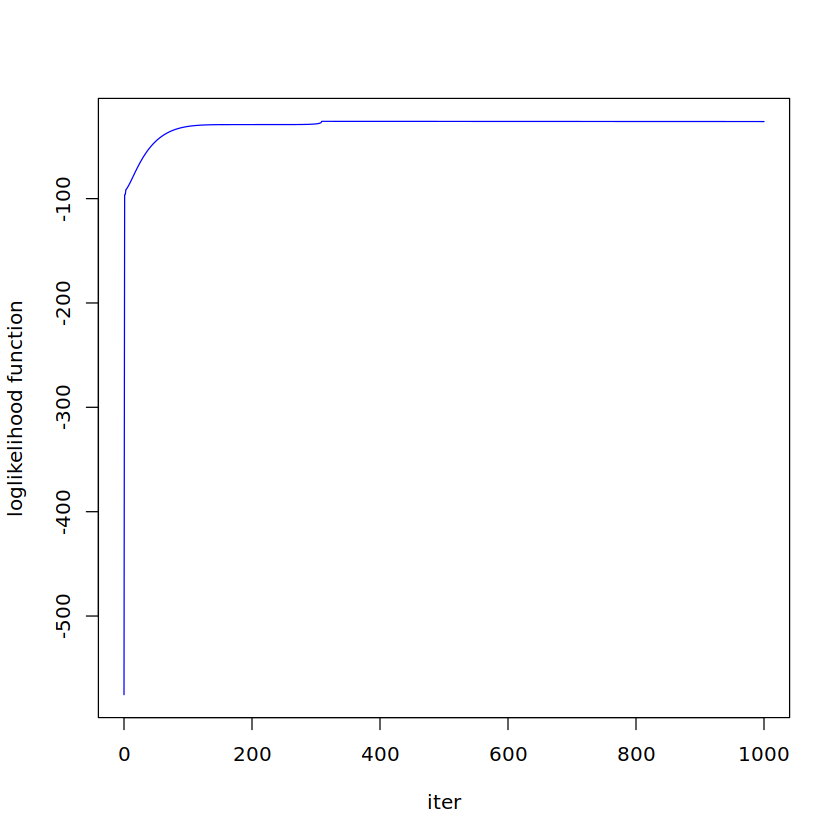

In [22]:
max_iter <- 1000
threshold <- 1e-5
start_a <- 0.05
init_params <- list(
    k= runif(1,min=0, max=1),
    r= runif(1,min=0, max=1),
    var=runif(1,min=0, max=1)
)
M <- -fisher_matrix_func(t, init_params)
sprintf("Starting point: K=%.4f, r=%.4f, var=%.4f", init_params$k, init_params$r, init_params$var)

result <- bfgs_optimizer(t, y, max_iter, threshold, init_params, M, start_a)
plot(
    result$history$iter,
    result$history$obj_val,
    type = 'l',
    col = 'blue',
    xlab = 'iter',
    ylab = 'loglikelihood function'
)

sprintf("Optimal points: K=%.4f, r=%.4f, var=%.4f", result$params$k, result$params$r, result$params$var)
sprintf("Final loglikelihood value: %.4f", loglikelihood_func(t, y, result$params))
sprintf("Best loglikelihood value: %.4f", max(result$history$obj_val))